## Research Question

#### Do different mallet types create different sound qualities when used to play a marimba?  Can these differences be used to train a computer to detect the type of mallet used?

Any professional percussionist will have a gig bag full of various types of mallets.  Mallets can vary not only by the type of handle used but also by the material on the head of the mallet as well.  A percussionist will actually select a specific mallet head based on the piece that is being played.  Each piece played requires a specific sound from the instrument and therefore a specific mallet type will be used.     

This video is a recording of Keiko Abe, the greatest marimba player.  In this video you can see she uses different techniques when playing the instrument from using split wood to yarn mallets and even using the handles of the mallets.  By listening to these different techniques you can easily hear the different sound quality pulled from the instrument.  
https://youtu.be/yOjKBRe1SuM?list=RDyOjKBRe1SuM

Mallets are to percussionists as a computer is to a programmer.   

There a lot of different steps to the analysis of sound.  By using sound analysis techniques, coupled with visualizations can we really see the difference betweeen different types of mallets being played on a marimba.  If we can see these differences can we then use a computer learning algorithm and ask the computer what type of mallet was used?


The sound samples used in this notebook were obtained from the University of Iowa Electronic Music Studio website at http://theremin.music.uiowa.edu/MIS-Pitches-2012/MISMarimba2012.html.  These samples were downloaded and used in analysis using the Librosa python library.  This data was used to create a pandas dataframe for further analysis.  visualizations were created using Librosa and matplotlib libraries.  The sklearn module is also used to use a K Nearest Neighbors Algorithm to train the computer.  As you will see with the visualizations, and with the KNN algorithm is possible to visualize difference between the different types of mallets used, and it is possible to train a computer to detect the type of mallet that was used to play the marimba.

Creating the dataframe for all the notes on the marimbia using three different mallet types can take a little time.  Please be patient.  Also I have found that running the KNN algorithm can take a little time as well. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import IPython.display as ipd
import pandas as pd

In [2]:
import librosa.display

## Turn the files into numpy arrays

This first thing we do is take the files that we want to analyze and turn them into numpy arrays. Librosa has a function librosa.load which does this for us. Not only does it give is the sound wave as a numpy array it also gives us the sampling rate which by default is 22050. Our files were created with a sample rate of 44100. We are going to load the files with the 44100 sample rate rather than the librosa default. 

In [3]:
yarn_c4, sr = librosa.load('yarn/Marimba.yarn.ff.C4.stereo.aif', sr=44100)
rubber_c4, _ = librosa.load('rubber/Marimba.rubber.ff.C4.stereo.aif', sr=44100)
cord_c4, _ = librosa.load('cord/Marimba.cord.ff.C4.stereo.aif', sr=44100)
dead_c4, _ = librosa.load('dead/Marimba.deadstroke.ff.C4.stereo.aif', sr=44100)

## Next we are going to visualize the waveforms from the different files

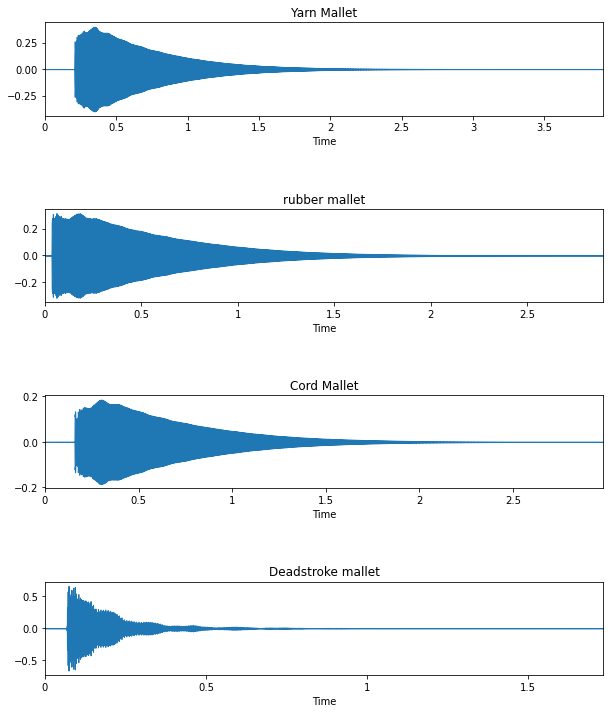

In [273]:
plt.figure(figsize = (10,12))

plt.subplot(4,1,1)
librosa.display.waveplot(yarn_c4)
plt.title('Yarn Mallet')

plt.subplot(4,1,2)
librosa.display.waveplot(rubber_c4)
plt.title('rubber mallet')

plt.subplot(4,1,3)
librosa.display.waveplot(cord_c4)
plt.title('Cord Mallet')

plt.subplot(4,1,4)
librosa.display.waveplot(dead_c4)
plt.title('Deadstroke mallet')

plt.subplots_adjust(hspace=1)

If you look at these waveforms you can see that they are all of a different length.  This is going to cause problems when we start playing with this data.  Our next step is to set these arrays so that they are all the same length. We are going to make them the length of the shortest waveform which is the deadstroke.  Here we are doing this by slicing the arrays.  As our dataset grows, we will easily be able to accomplish this task with pandas.   

In [4]:
yarn_c4 = yarn_c4[:len(dead_c4)]
rubber_c4 = rubber_c4[:len(dead_c4)]
cord_c4 = cord_c4[:len(dead_c4)]

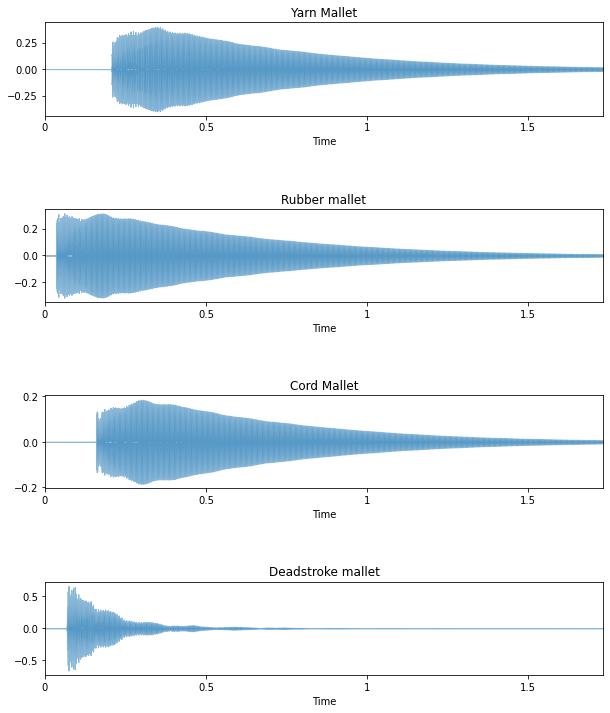

In [5]:
# Visualize the waveforms to verify they are all the smae length
plt.figure(figsize = (10,12))

plt.subplot(4,1,1)
librosa.display.waveplot(yarn_c4, alpha = 0.5)
plt.title('Yarn Mallet')

plt.subplot(4,1,2)
librosa.display.waveplot(rubber_c4, alpha = 0.5)
plt.title('Rubber mallet')

plt.subplot(4,1,3)
librosa.display.waveplot(cord_c4, alpha = 0.5)
plt.title('Cord Mallet')

plt.subplot(4,1,4)
librosa.display.waveplot(dead_c4, alpha = 0.5)
plt.title('Deadstroke mallet')

plt.subplots_adjust(hspace=1)

There are different ways we can look at these waveforms using time-domain features.  Some of these features include Amplitude envelope, root-mean-square energy and zero-crossing rate.  

First we will look at the amplitude envelope.  This is a calculation of the max amplitude value of all the samples in a frame.  After that we will plot out the root-mean-square of the waveforms as well as the zero-rossing-rate.

In [6]:
FRAME_SIZE = 1024
HOP_SIZE = 512

def amplitude_envelope(signal, frame_size, hop_length):
    amplitude_envelope = []
    
    # calculate AE for each frame
    for i in range(0, len(signal), hop_length):
        current_frame_amplitude_envelope = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_envelope)
        
    return np.array(amplitude_envelope)

In [7]:
ae_yarn = amplitude_envelope(yarn_c4, FRAME_SIZE, HOP_SIZE)
ae_rubber = amplitude_envelope(rubber_c4, FRAME_SIZE, HOP_SIZE)
ae_cord = amplitude_envelope(cord_c4, FRAME_SIZE, HOP_SIZE)
ae_dead = amplitude_envelope(dead_c4, FRAME_SIZE, HOP_SIZE)

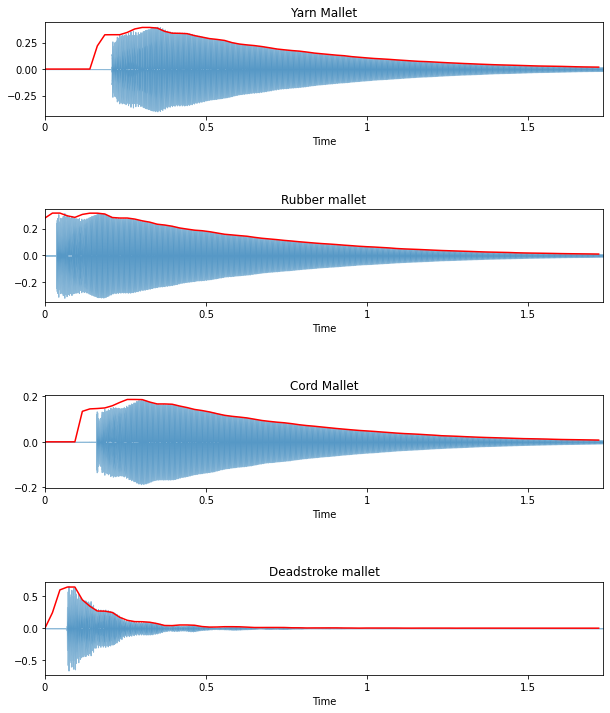

In [8]:
# Visualize the waveforms and amplitude envelope 

frames = range(0, ae_yarn.size)
t = librosa.frames_to_time(frames, hop_length = HOP_SIZE)

plt.figure(figsize = (10,12))

plt.subplot(4,1,1)
librosa.display.waveplot(yarn_c4, alpha = 0.5)
plt.plot(t, ae_yarn, color = 'r')
plt.title('Yarn Mallet')

plt.subplot(4,1,2)
librosa.display.waveplot(rubber_c4, alpha = 0.5)
plt.plot(t, ae_rubber, color='r')
plt.title('Rubber mallet')

plt.subplot(4,1,3)
librosa.display.waveplot(cord_c4, alpha = 0.5)
plt.plot(t, ae_cord, color='r')
plt.title('Cord Mallet')

plt.subplot(4,1,4)
librosa.display.waveplot(dead_c4, alpha = 0.5)
plt.plot(t, ae_dead, color='r')
plt.title('Deadstroke mallet')

plt.subplots_adjust(hspace=1)

In [9]:
# Get Root Maen Square of waveforms

rms_yarn = librosa.feature.rms(yarn_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
rms_rubber = librosa.feature.rms(rubber_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
rms_cord = librosa.feature.rms(cord_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
rms_dead = librosa.feature.rms(dead_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]

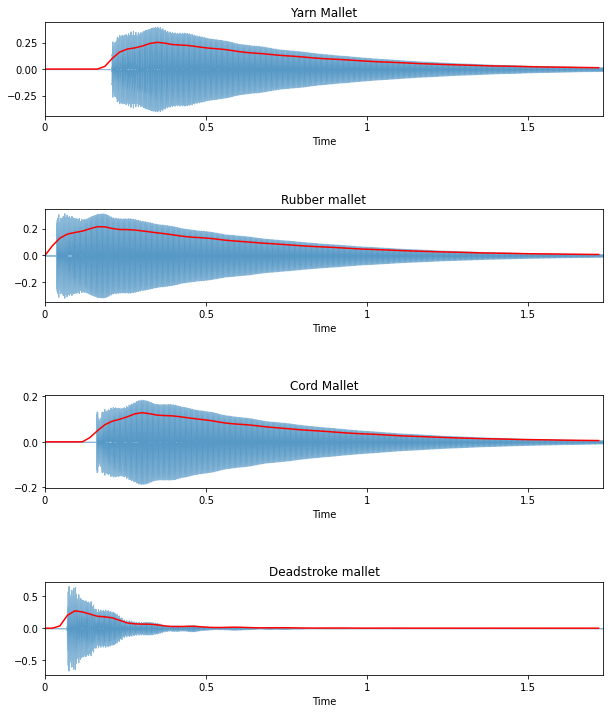

In [10]:
plt.figure(figsize = (10,12))

plt.subplot(4,1,1)
librosa.display.waveplot(yarn_c4, alpha = 0.5)
plt.plot(t, rms_yarn, color = 'r')
plt.title('Yarn Mallet')

plt.subplot(4,1,2)
librosa.display.waveplot(rubber_c4, alpha = 0.5)
plt.plot(t, rms_rubber, color='r')
plt.title('Rubber mallet')

plt.subplot(4,1,3)
librosa.display.waveplot(cord_c4, alpha = 0.5)
plt.plot(t, rms_cord, color='r')
plt.title('Cord Mallet')

plt.subplot(4,1,4)
librosa.display.waveplot(dead_c4, alpha = 0.5)
plt.plot(t, rms_dead, color='r')
plt.title('Deadstroke mallet')

plt.subplots_adjust(hspace=1)

In [11]:
# Zero Crossing Rate

zcr_yarn = librosa.feature.zero_crossing_rate(yarn_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
zcr_rubber = librosa.feature.zero_crossing_rate(rubber_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
zcr_cord = librosa.feature.zero_crossing_rate(cord_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
zcr_dead = librosa.feature.zero_crossing_rate(dead_c4, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]

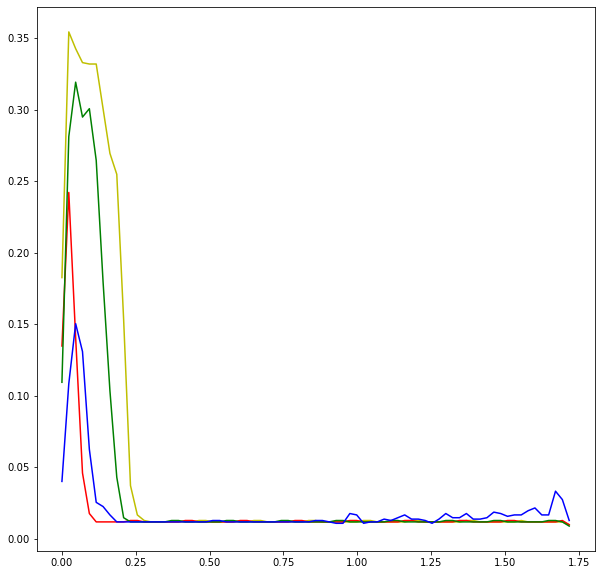

In [12]:
# Visualise zero crossing rate

plt.figure(figsize=(10,10))
plt.plot(t, zcr_yarn, color='y')
plt.plot(t, zcr_rubber, color='r')
plt.plot(t, zcr_cord, color='g')
plt.plot(t, zcr_dead, color='b')

In [13]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)
    
    plt.figure(figsize=(18, 5))
    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    num_frequency_bins = int(len(frequency) * f_ratio)
    plt.plot(frequency[:num_frequency_bins], magnitude_spectrum[:num_frequency_bins])
    plt.xlabel('Frequency (Hz)')
    plt.title(title)
    plt.show()

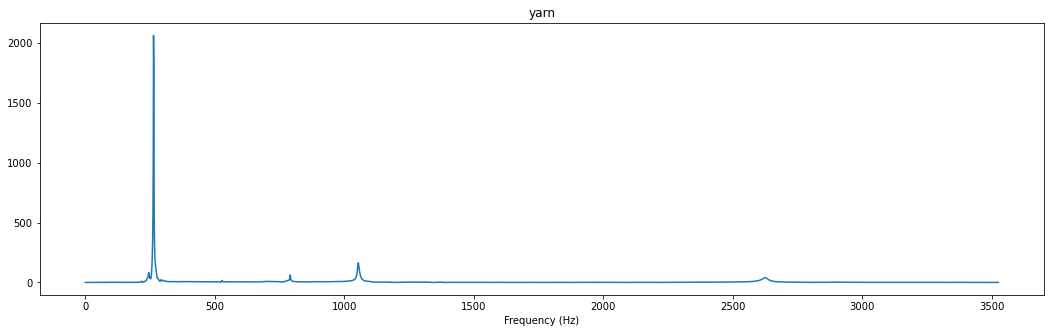

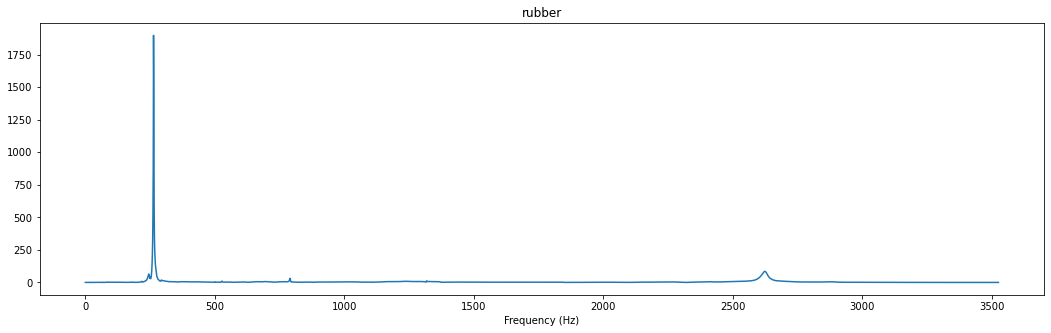

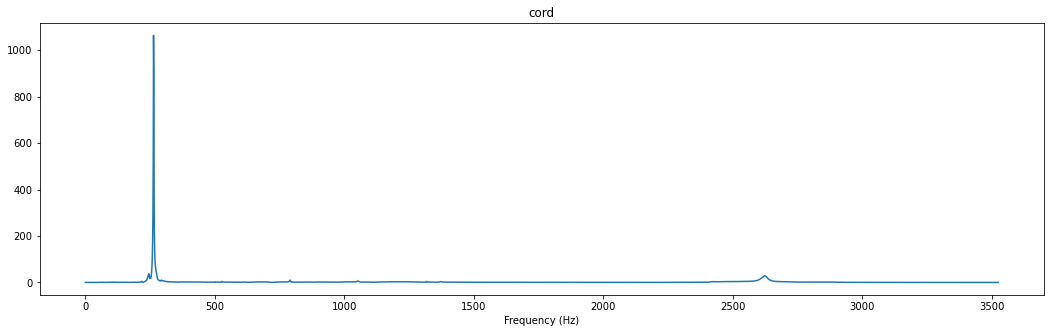

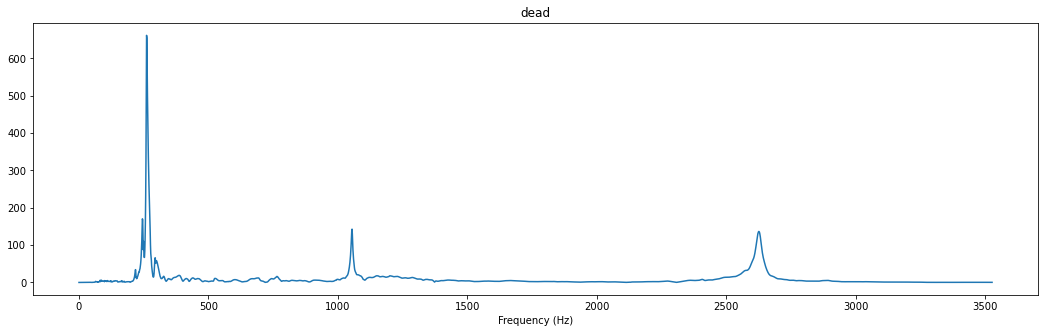

In [18]:
plot_magnitude_spectrum(yarn_c4, 'yarn', sr, 0.08)
plot_magnitude_spectrum(rubber_c4, 'rubber', sr, 0.08)
plot_magnitude_spectrum(cord_c4, 'cord', sr, 0.08)
plot_magnitude_spectrum(dead_c4, 'dead', sr, 0.08)

The above shows the frequency spectrum for middle C or C4 being played on a marimba. The fundamental frequency for C4 is 262Hz. Every multiple of the fundamental frequency is considered a harmonic, and this provides our ear with the timber of the sound or the sound quality. A Violin playing C4 would have different harmonics than a trumpet and so forth and so on. 

All of the samples above we can see the first and the 10th harmonics. In the deadstroke option we see the fourth harmonic. In the other samples we may see a little bit of the second and third harmonics to varying degrees. So, just as in the time domain we do see some differences in the notes based on the type of mallet used in the frequency domain we also see some differences in the type of mallet.  

Next, we are going to look at these waveforms as a function of time, amplitude and frequency. To do this we are going to use a heatmap to make a spectrogram. 

In [19]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [20]:
def plot_spectrogram(Y, sr, hop_length, y_axis='log'):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y,
                            sr=sr,
                            hop_length=hop_length,
                            x_axis='time',
                            y_axis=y_axis)
    plt.colorbar(format='%+2.f')

C:\Users\amand\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\amand\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\amand\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


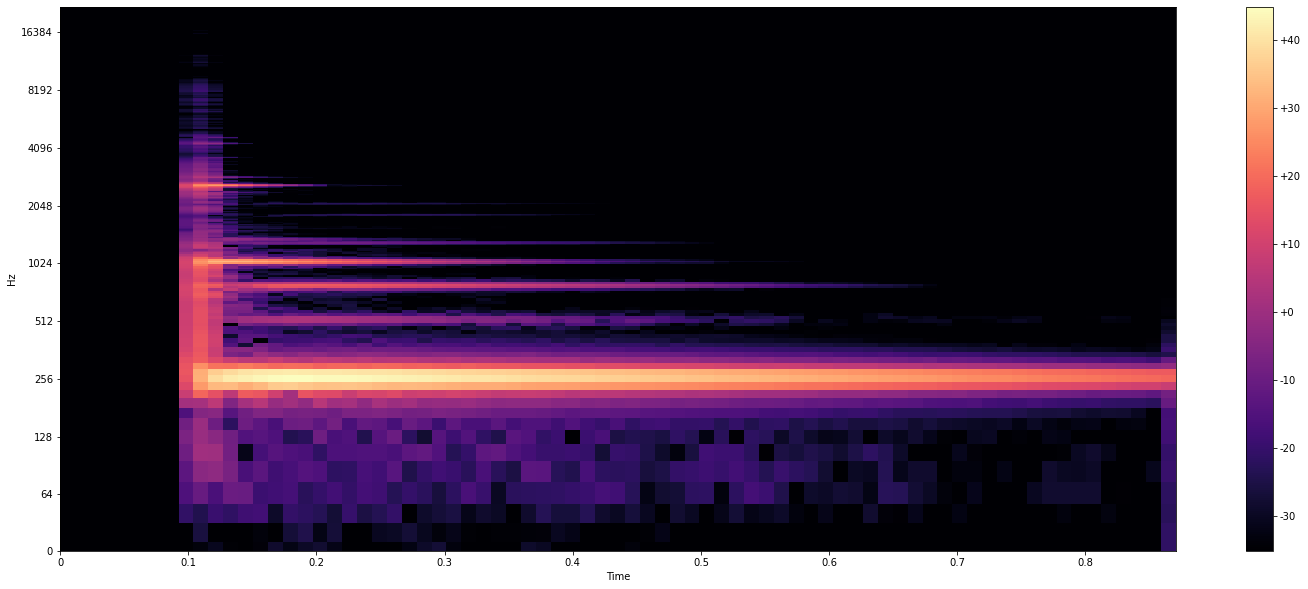

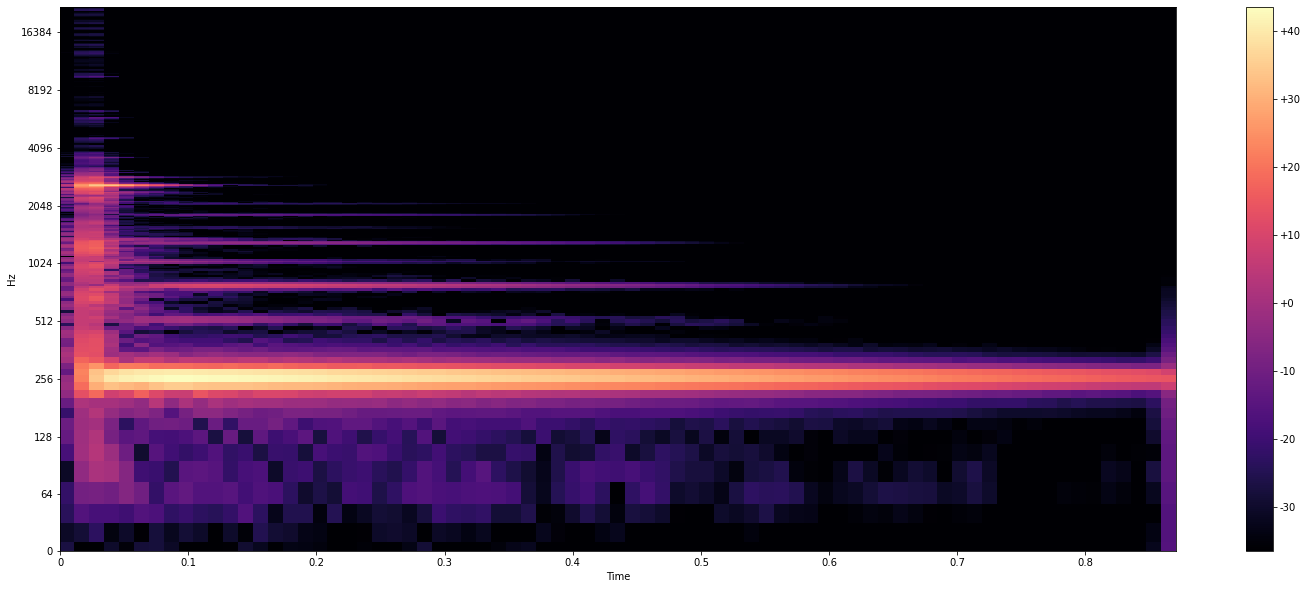

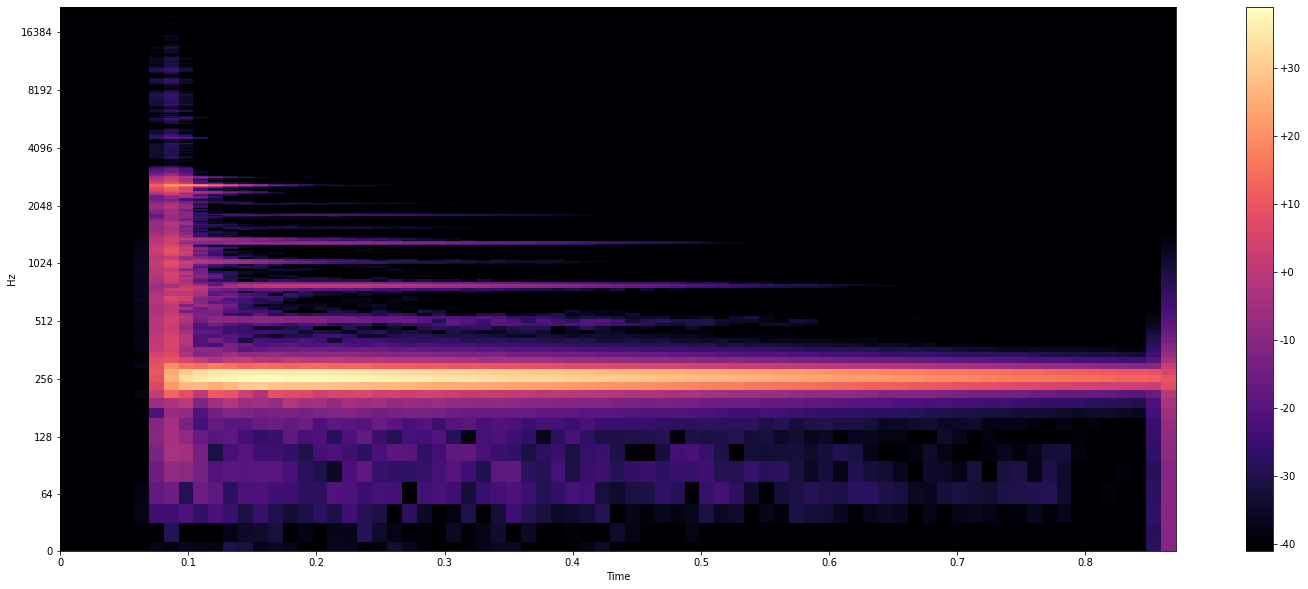

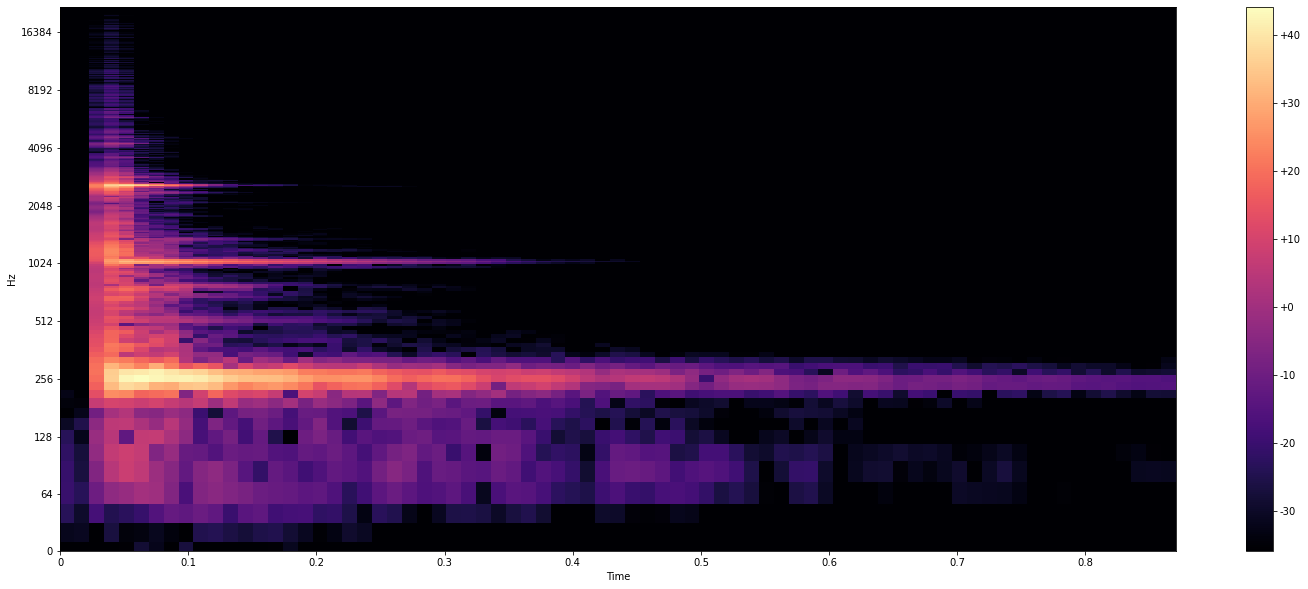

In [21]:
s_yarn = librosa.stft(yarn_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
s_rubber = librosa.stft(rubber_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
s_cord = librosa.stft(cord_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
s_dead = librosa.stft(dead_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

y_yarn = librosa.power_to_db(np.abs(s_yarn)**2)
y_rubber = librosa.power_to_db(np.abs(s_rubber)**2)
y_cord = librosa.power_to_db(np.abs(s_cord)**2)
y_dead = librosa.power_to_db(np.abs(s_dead)**2)

plot_spectrogram(y_yarn, sr, HOP_SIZE, y_axis='log')
plot_spectrogram(y_rubber, sr, HOP_SIZE, y_axis='log')
plot_spectrogram(y_cord, sr, HOP_SIZE, y_axis='log')
plot_spectrogram(y_dead, sr, HOP_SIZE, y_axis='log')

We plotted the y axis on a log scale because well, sound works better on a log scale.

I think it is hard to see a difference here between the yarn, rubber and cord mallets.  The only spectrogram that may look different is the one for the deadstroke.    

Next, we are going to apply a filter to our sounds.  Specifically, we are going to apply a mel filter.  First let's visualize the filter itself. 

In [22]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=40)

In [23]:
filter_banks.shape

(40, 1025)

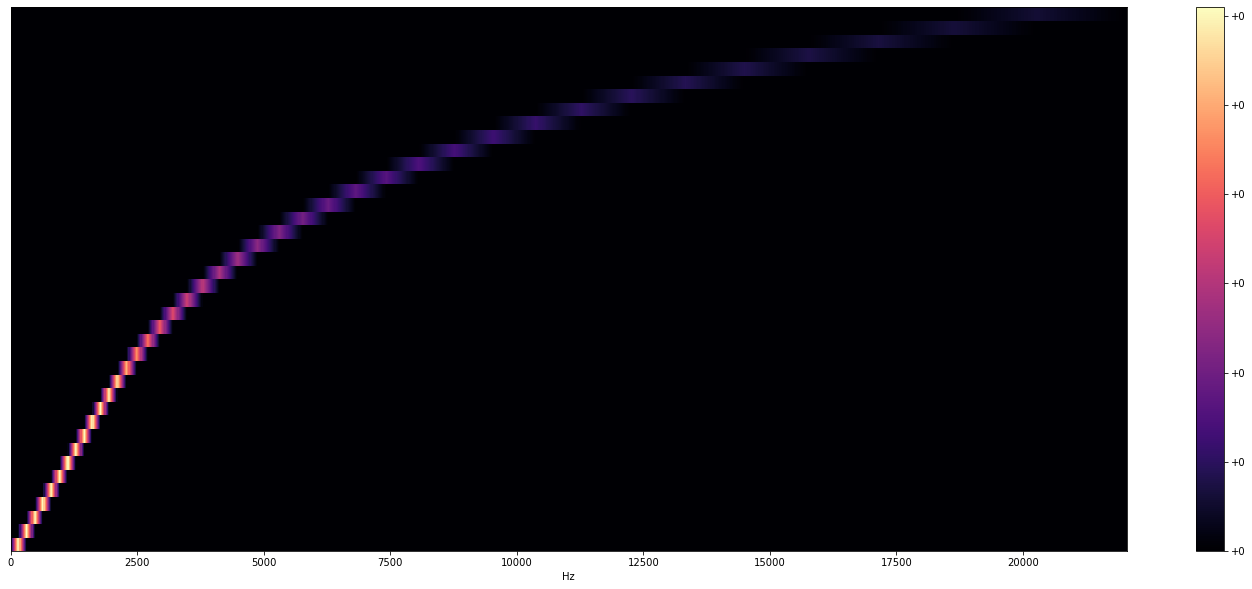

In [24]:
plt.figure(figsize=(25,10))
librosa.display.specshow(filter_banks, sr=sr, x_axis='linear')
plt.colorbar(format="%+2.f")
plt.show()

Next, we are actually going to use a librosa feature (function) called Mel Spectrogram to actually apply the filter to our sounds.  Then we will plot them again for visualization.  

In [27]:
def plot_mel_spectrogram(Y, sr, y_axis='log'):
    plt.figure(figsize=(25, 10))
    mel_spectrogram = librosa.feature.melspectrogram(Y, sr=sr, n_fft=2048, hop_length=512, n_mels=90)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    librosa.display.specshow(log_mel_spectrogram,
                            x_axis='time',
                            y_axis='mel',
                            sr=sr)
    plt.colorbar(format="%+2.f")

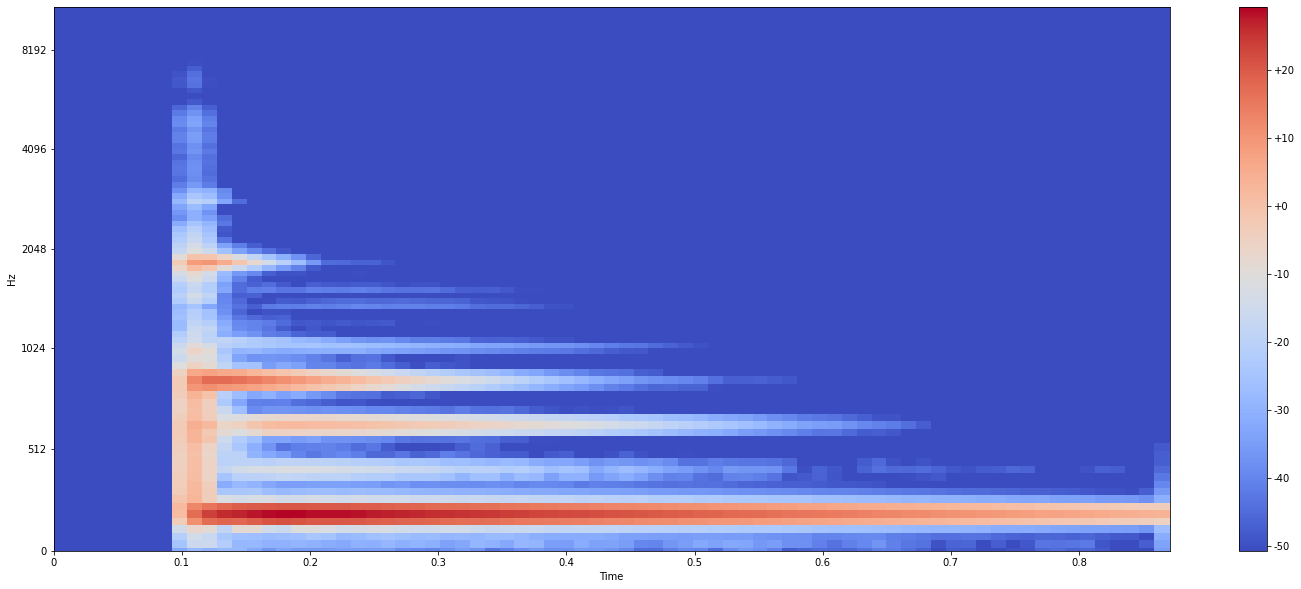

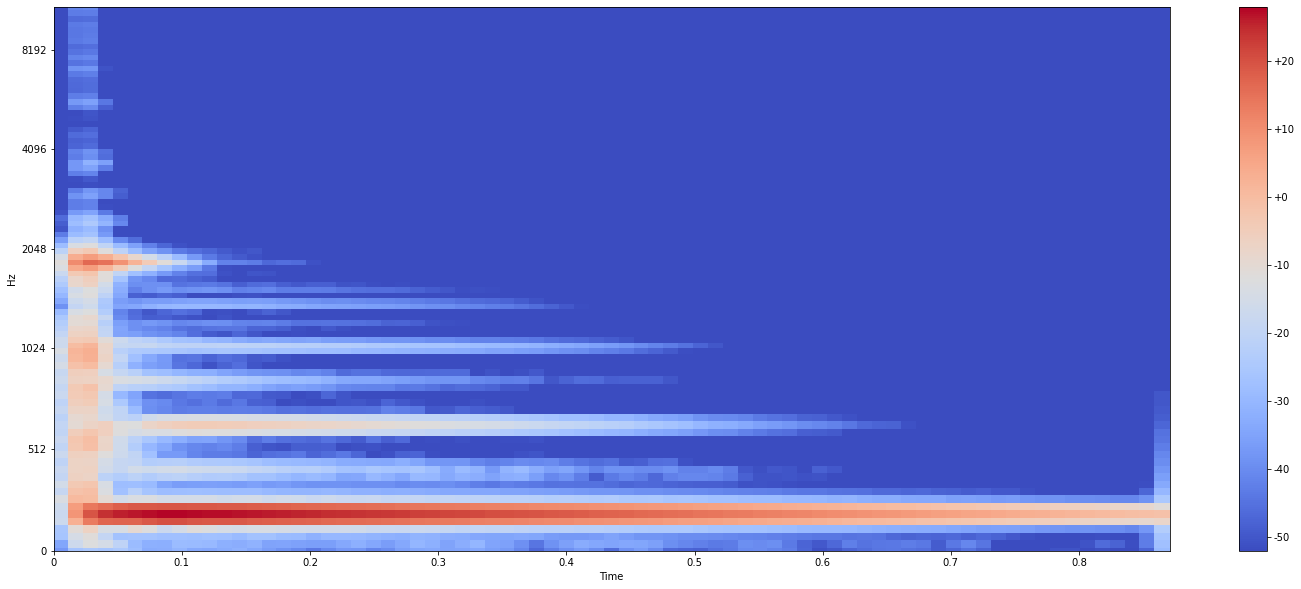

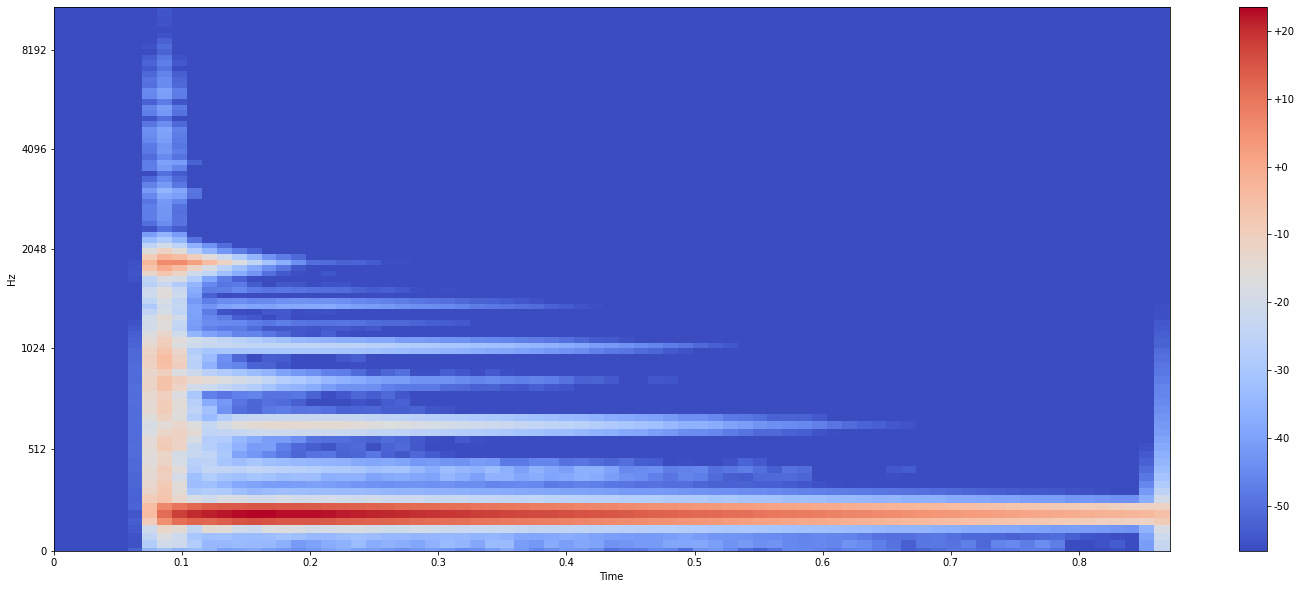

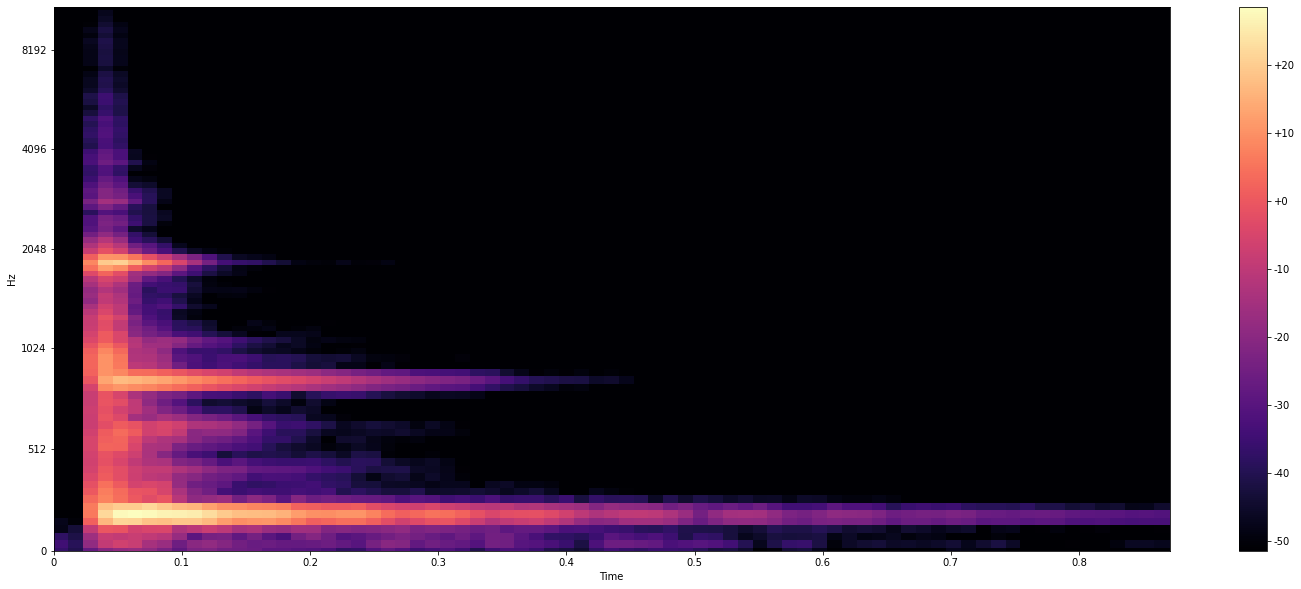

In [28]:
plot_mel_spectrogram(yarn_c4, sr=sr)
plot_mel_spectrogram(rubber_c4, sr=sr)
plot_mel_spectrogram(cord_c4, sr=sr)
plot_mel_spectrogram(dead_c4, sr=sr)

I think plotting them with the Mel Spectrogram allows use to see a little more variation between the different types of mallets used. 

Next we are going to extract the MFCC, Mel-Frequency Cepstrail Coeficients. We are going to pretend that the log_mel_spectrum above is a signal and we are going to take the cosine transform of that signal. We are then going to look at the amplitudes of that result. This will give us the MFCCs 

In [29]:
def extract_mfcc(Y, n_mfcc=13, sr=sr):
    mfccs = librosa.feature.mfcc(Y, n_mfcc=n_mfcc, sr=sr)
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(mfccs, x_axis = 'time', sr=sr)
    plt.colorbar(format="%+2.f")

    return mfccs

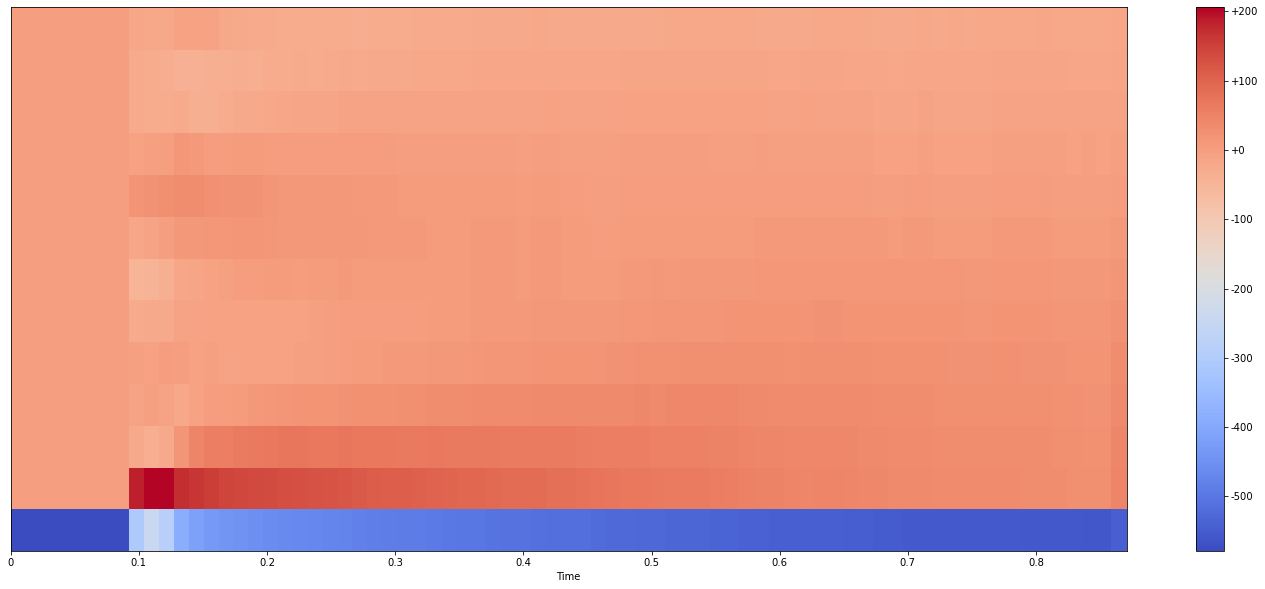

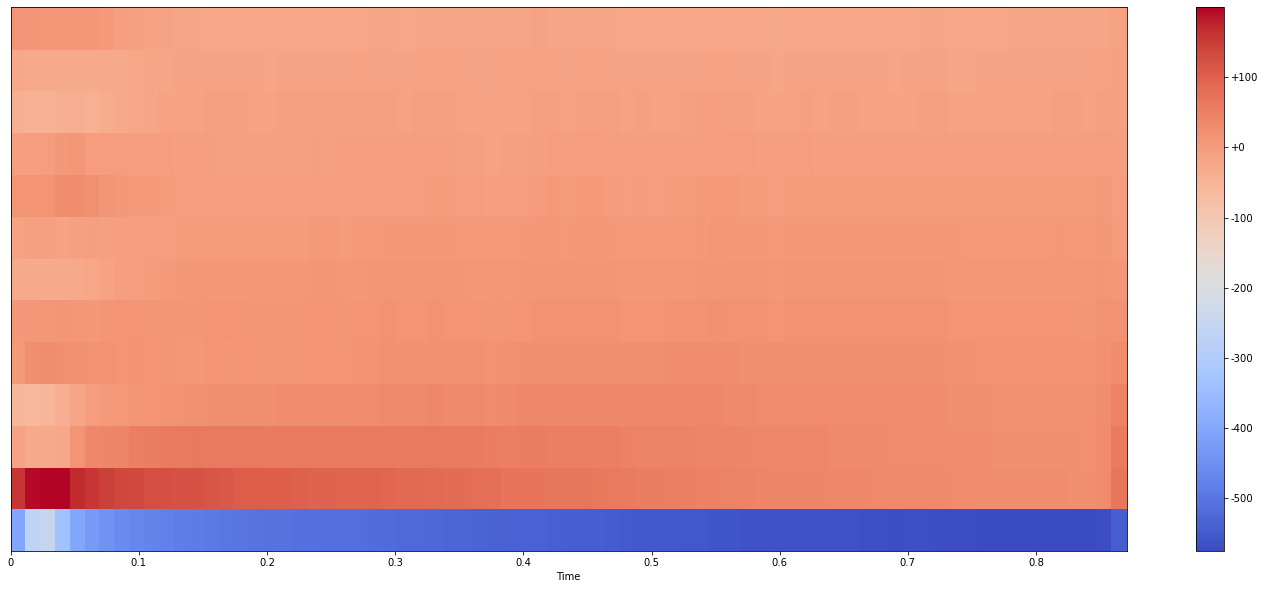

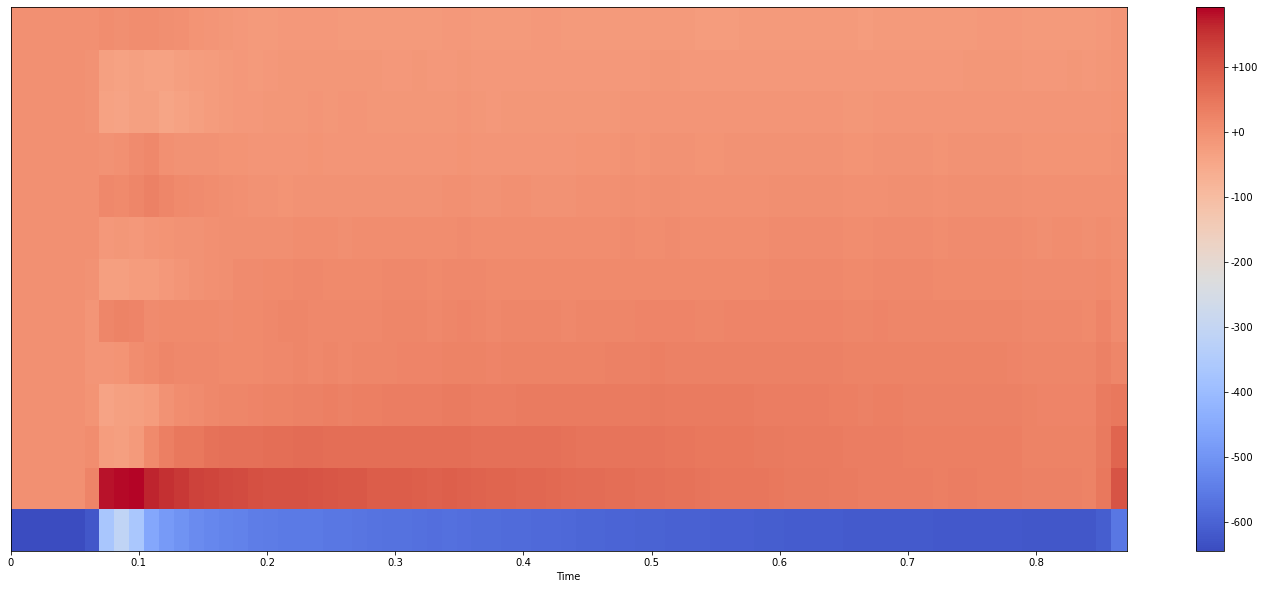

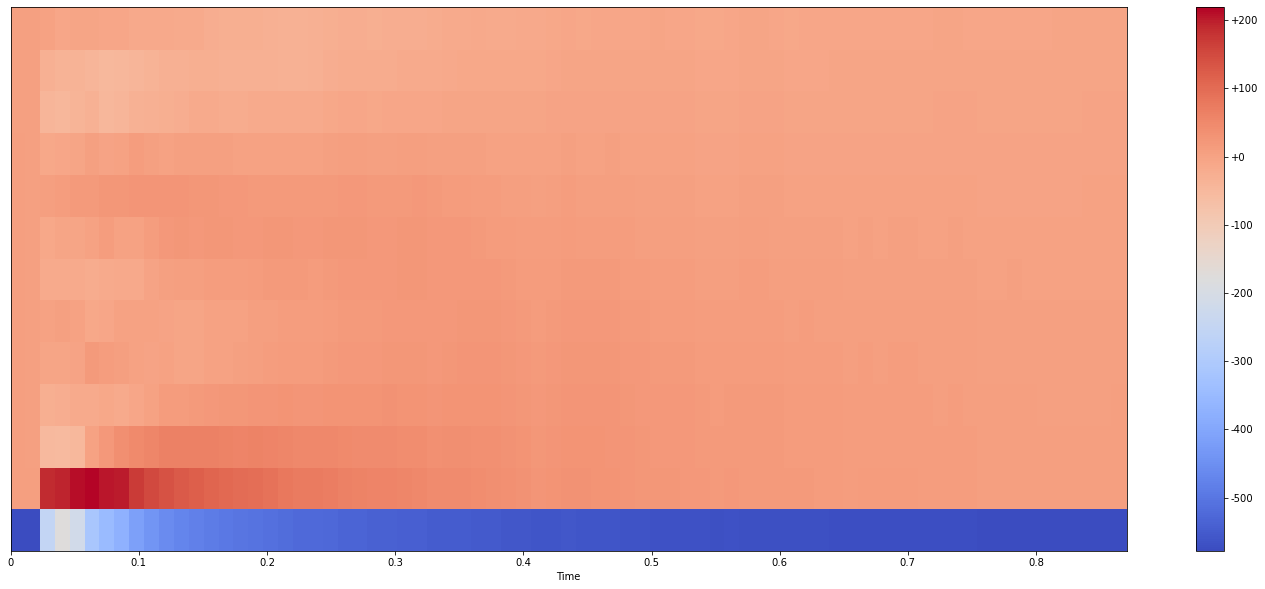

In [30]:
yarn_mfcc = extract_mfcc(yarn_c4)
rubber_mfcc = extract_mfcc(rubber_c4)
cord_mfcc = extract_mfcc(cord_c4)
dead_mfcc = extract_mfcc(dead_c4)

I can see a little bit of a difference between from the rubber mallet with using MFCCs, but the yarn and cord mallets look pretty much the same here.   

Another manipulation we can do is to take the first and second derivatives of the MFCCs.  Let's see what that give us.   

In [31]:
def mfcc(Y, n_mfcc=13, sr=sr):
    mfccs = librosa.feature.mfcc(Y, n_mfcc=n_mfcc, sr=sr)
    return mfccs

def delta_mfcc(mfccs):
    delta_mfccs = librosa.feature.delta(mfccs)
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(delta_mfccs, x_axis = 'time', sr=sr)
    plt.colorbar(format="%+2.f")
    
    return delta_mfccs

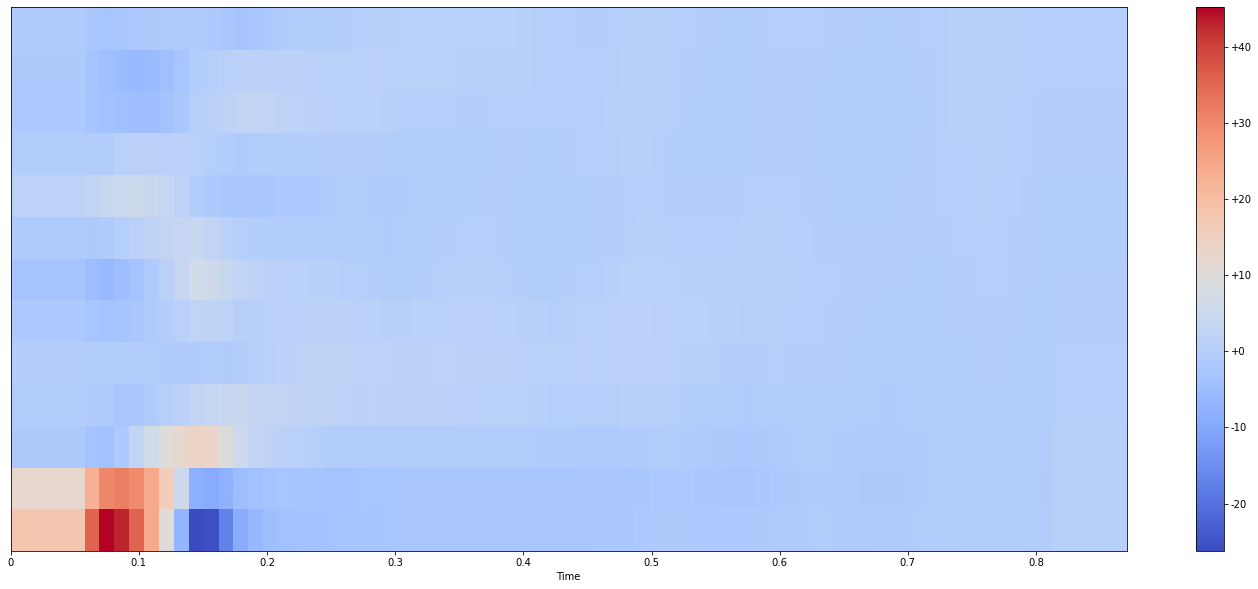

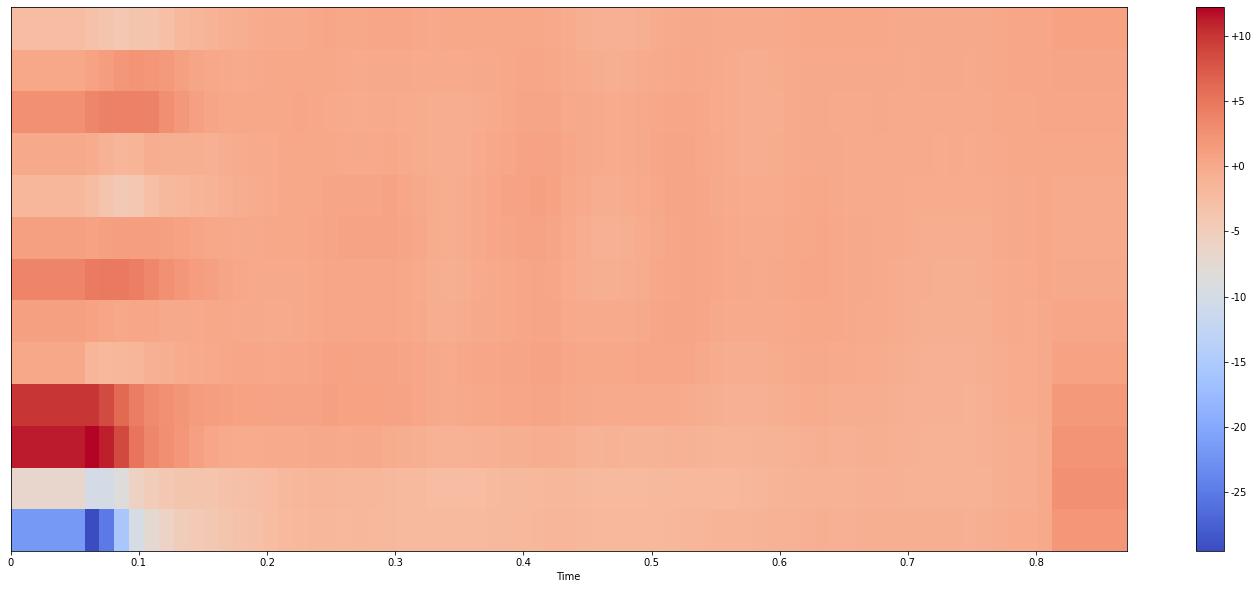

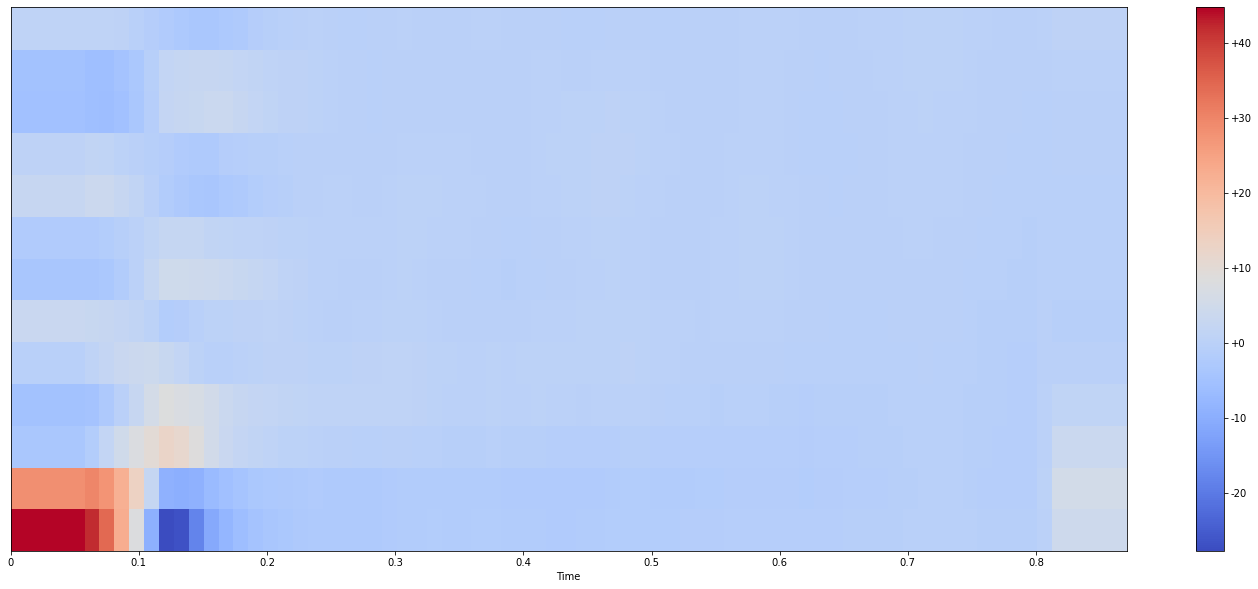

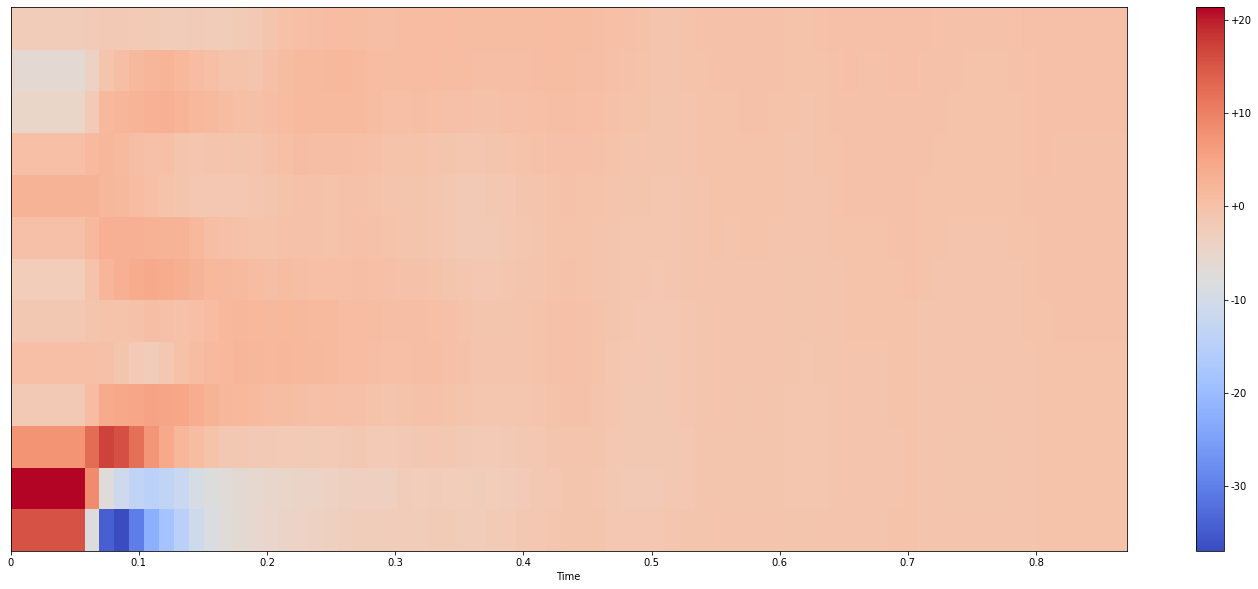

In [32]:
yarn_delta_mfcc = delta_mfcc(mfcc(yarn_c4))
rubber_delta_mfcc = delta_mfcc(mfcc(rubber_c4))
cord_delta_mfcc = delta_mfcc(mfcc(cord_c4))
dead_delta_mfcc = delta_mfcc(mfcc(dead_c4))

Well, that looks pretty similar to the MFCCs themselves.  Let's try the second dirivative.  

In [33]:
def delta2_mfcc(mfccs):
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(delta2_mfccs, x_axis = 'time', sr=sr)
    plt.colorbar(format="%+2.f")
    
    return delta2_mfccs

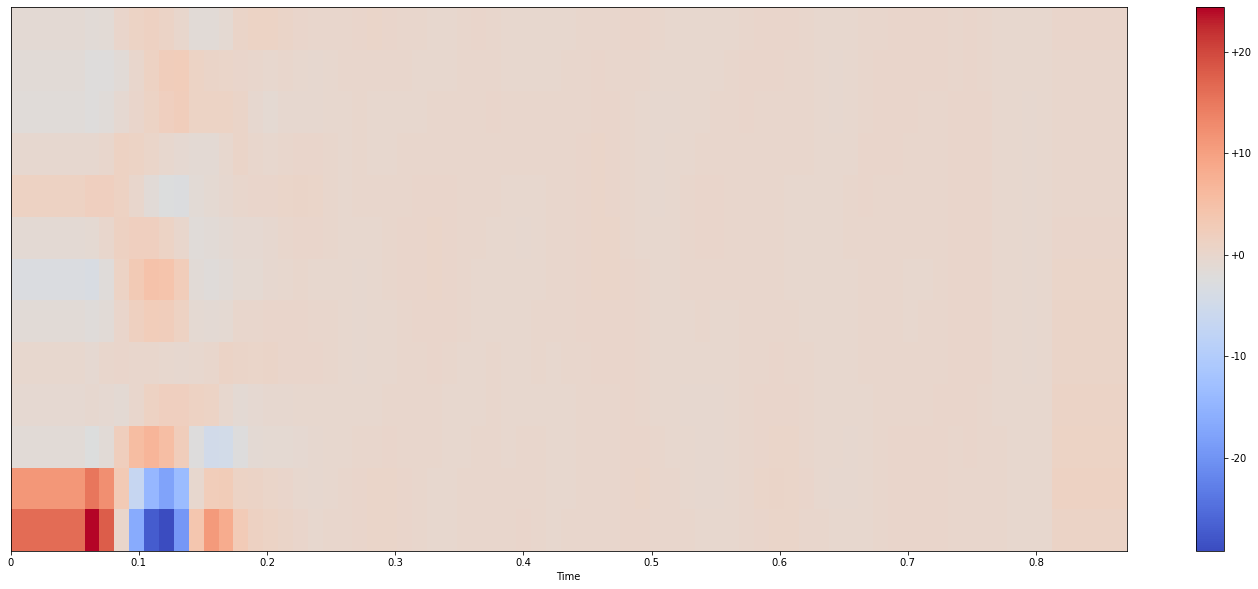

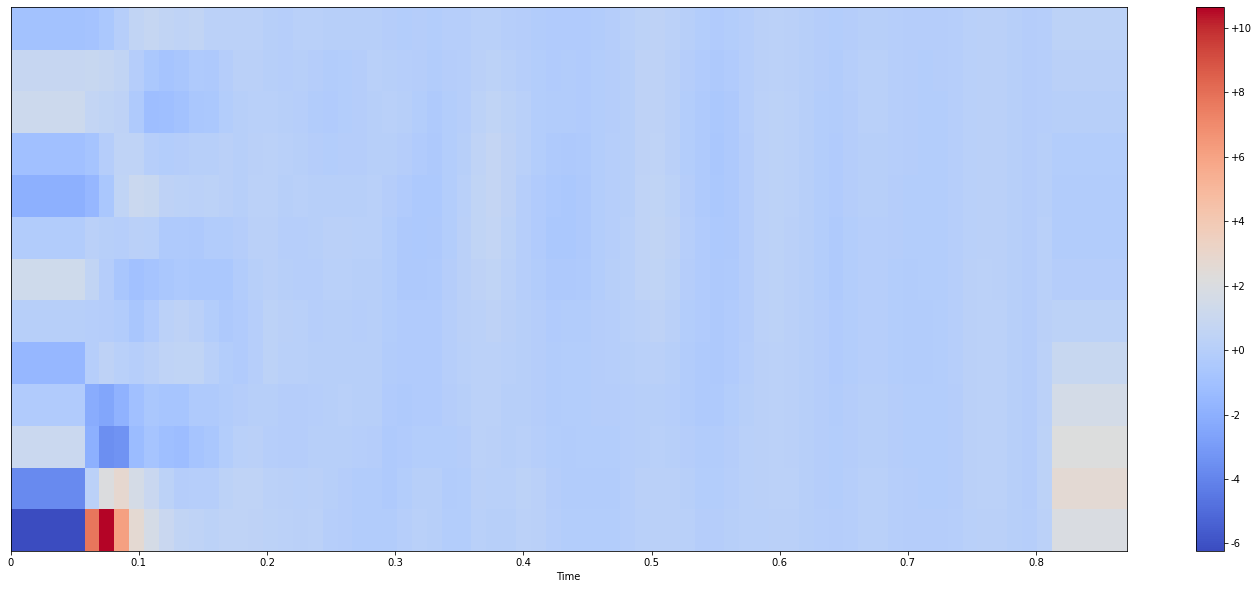

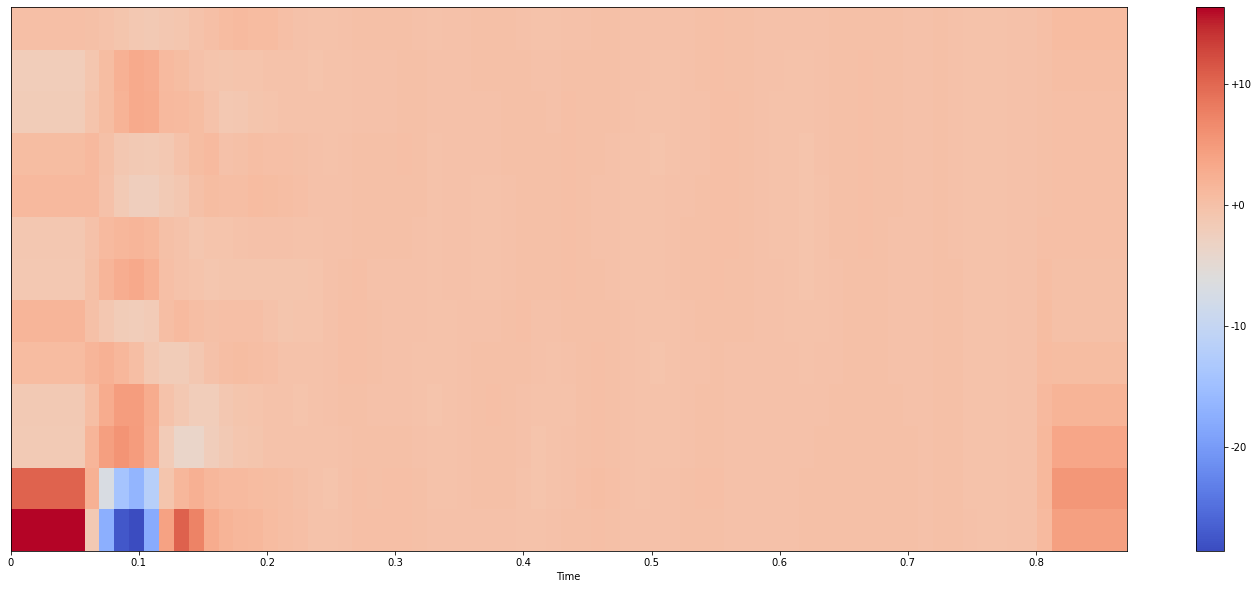

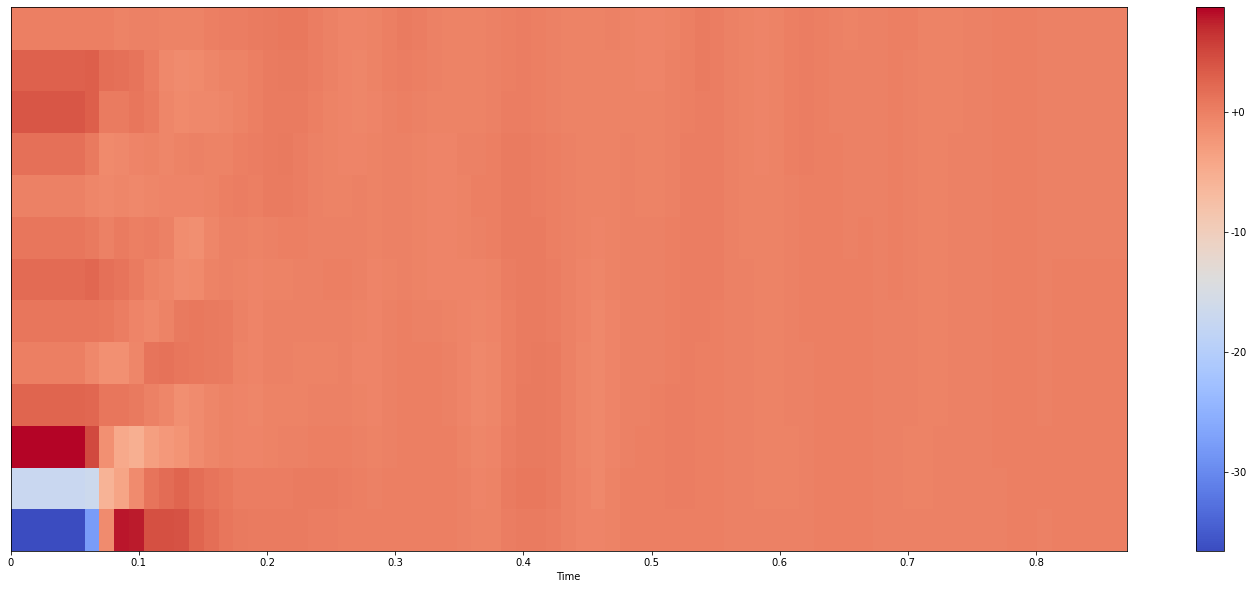

In [34]:
yarn_delta2_mfcc = delta2_mfcc(mfcc(yarn_c4))
rubber_delta2_mfcc = delta2_mfcc(mfcc(rubber_c4))
cord_delta2_mfcc = delta2_mfcc(mfcc(cord_c4))
dead_delta2_mfcc = delta2_mfcc(mfcc(dead_c4))

Now we can see a little more variation between the yarn and cord mallets.  

Let's try concatenating these three things together and see what happens. 

In [35]:
def comprehensive_mfcc(mfccs, delta_mfccs, delta2_mfccs):
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(comprehensive_mfccs, x_axis = 'time', sr=sr)
    plt.colorbar(format="%+2.f")

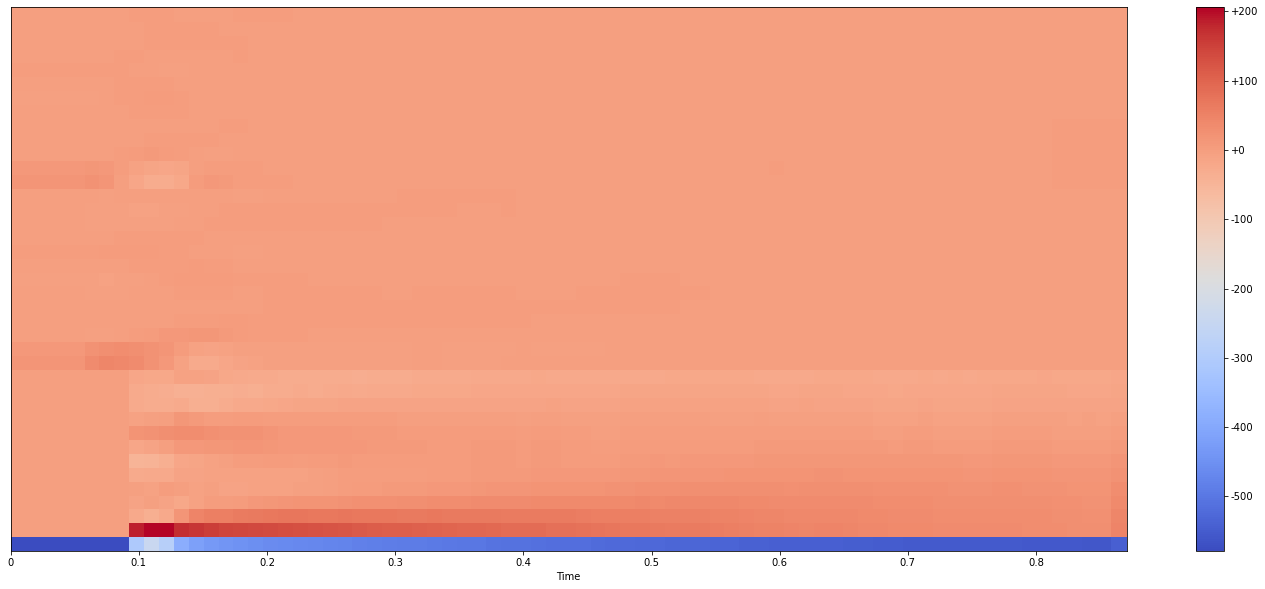

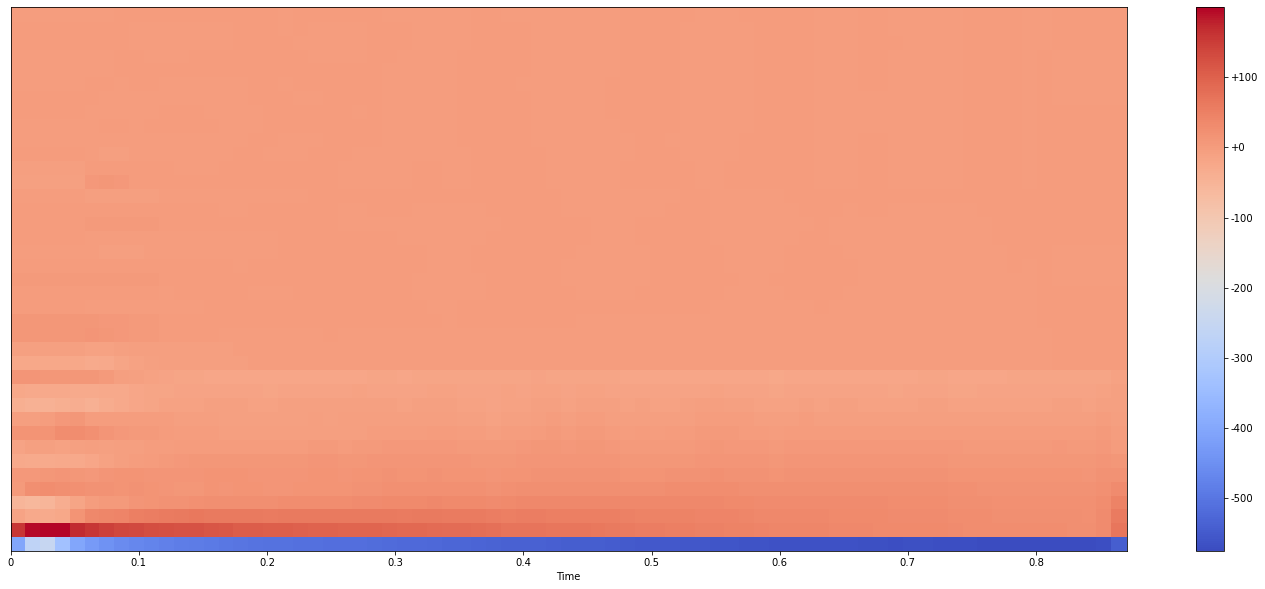

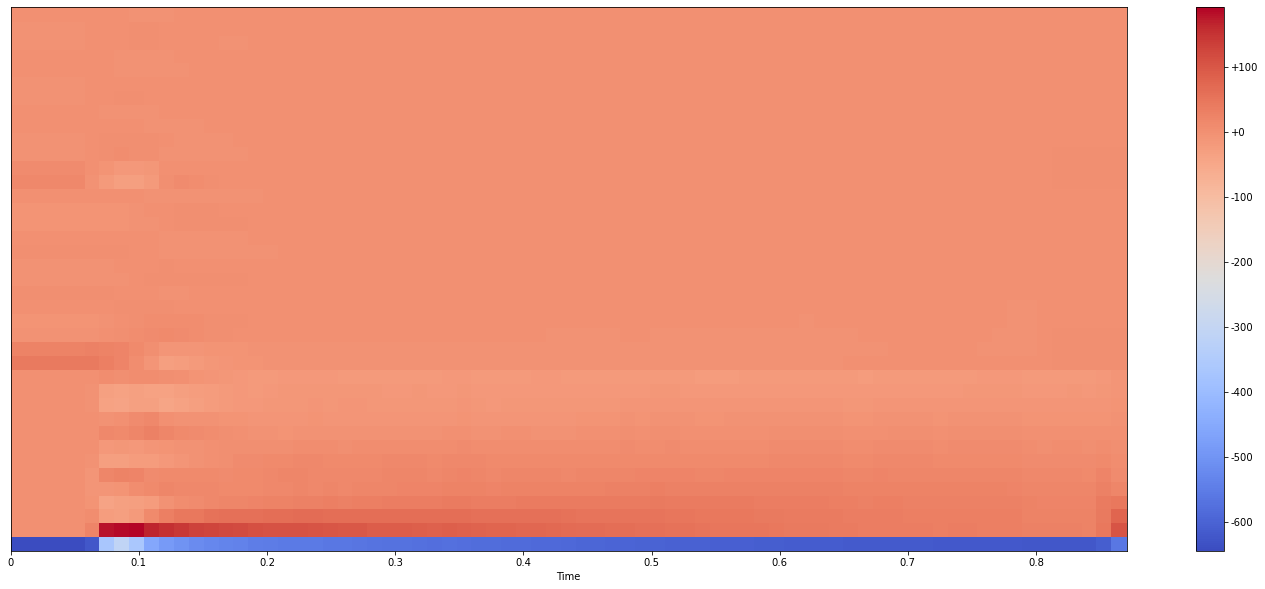

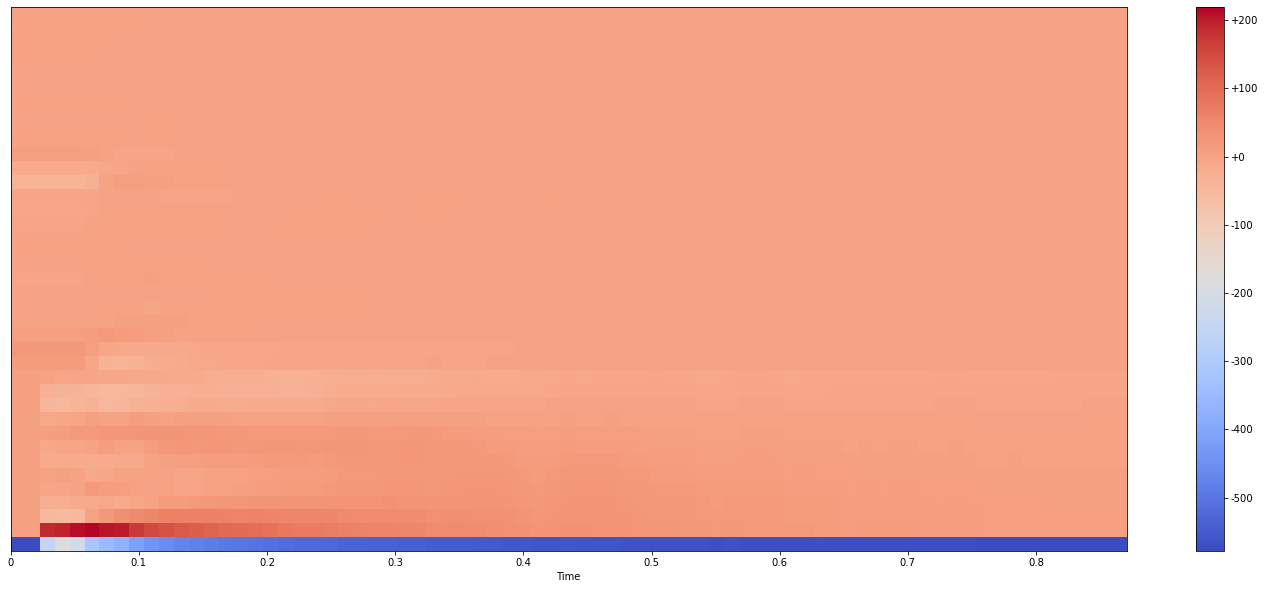

In [36]:
yarn_comprehensive = comprehensive_mfcc(yarn_mfcc, yarn_delta_mfcc, yarn_delta2_mfcc)
rubber_comprehensive = comprehensive_mfcc(rubber_mfcc, rubber_delta_mfcc, rubber_delta2_mfcc)
cord_comprehensive = comprehensive_mfcc(cord_mfcc, cord_delta_mfcc, cord_delta2_mfcc)
dead_comprehensive = comprehensive_mfcc(dead_mfcc, dead_delta_mfcc, dead_delta2_mfcc)

In [37]:
# Calculate band energy ratio

def calculate_split_frequency_bin(spectrogram, split_frequency, sample_rate):
    frequency_range = sample_rate/2
    frequency_delta_per_bin = frequency_range/spectrogram.shape[0]
    split_frequency_bin = np.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [38]:
yarn_spec = librosa.stft(yarn_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
rubber_spec = librosa.stft(rubber_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
cord_spec = librosa.stft(cord_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
dead_spec = librosa.stft(dead_c4, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [39]:
split_frequency_bin = calculate_split_frequency_bin(yarn_spec, 2000, 44100)
split_frequency_bin

92

In [40]:
def calculate_band_energy_ratio(spectrogram, split_frequency, sample_rate):
    split_frequency_bin = calculate_split_frequency_bin(yarn_spec, 2000, 44100)
    
    # move to the power spectrum
    power_spec = np.abs(spectrogram)**2
    power_spec = power_spec.T
    
    band_energy_ratio = []
    
    for i in power_spec:
        sum_power_low_frequencies = np.sum(i[:split_frequency_bin])
        sum_power_high_frequencies = np.sum(i[split_frequency_bin:])
        ber_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(ber_current_frame)
        
    return np.array(band_energy_ratio)

In [41]:
ber_yarn = calculate_band_energy_ratio(yarn_spec, 2000, 44100)
ber_rubber = calculate_band_energy_ratio(rubber_spec, 2000, 44100)
ber_cord = calculate_band_energy_ratio(cord_spec, 2000, 44100)
ber_dead = calculate_band_energy_ratio(dead_spec, 2000, 44100)

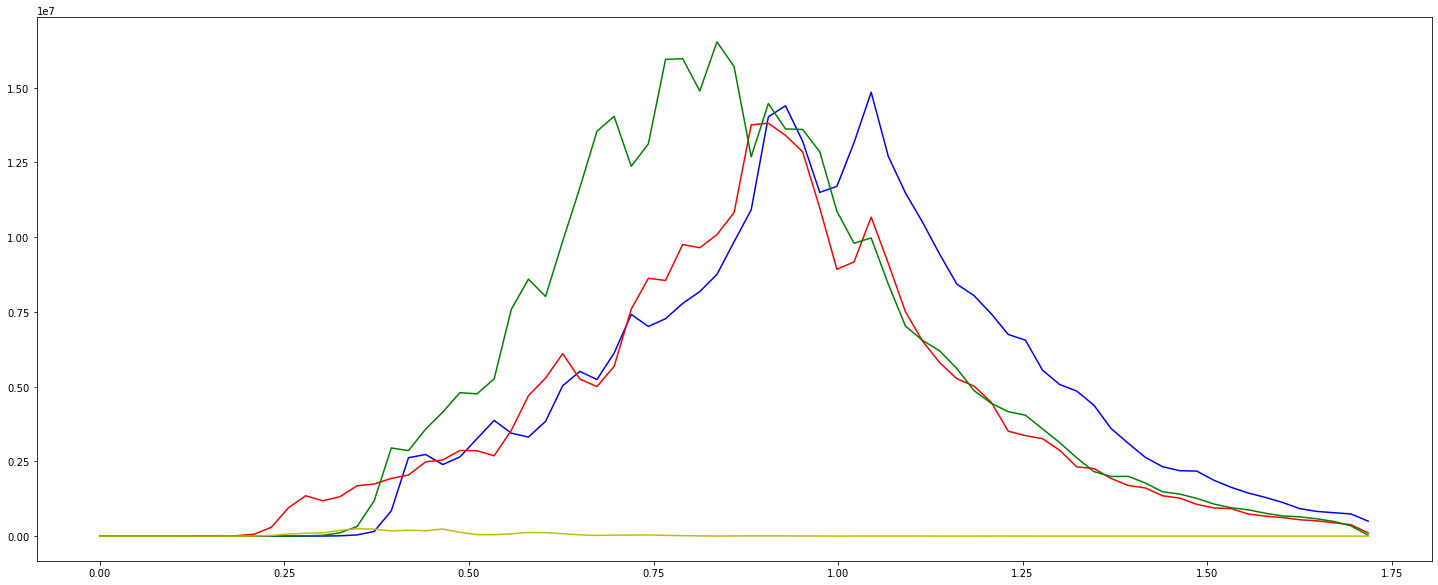

In [42]:
frames = range(len(ber_yarn))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

plt.figure(figsize=(25,10))
plt.plot(t, ber_yarn, color ='b')
plt.plot(t, ber_rubber, color ='r')
plt.plot(t, ber_cord, color = 'g')
plt.plot(t, ber_dead, color = 'y')
plt.show()

Another option is to calculate the spectral centroid

In [43]:
# Spectral centroid with librosa

sc_yarn = librosa.feature.spectral_centroid(y = yarn_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
sc_rubber = librosa.feature.spectral_centroid(y = rubber_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
sc_cord = librosa.feature.spectral_centroid(y = cord_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
sc_dead = librosa.feature.spectral_centroid(y = dead_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]

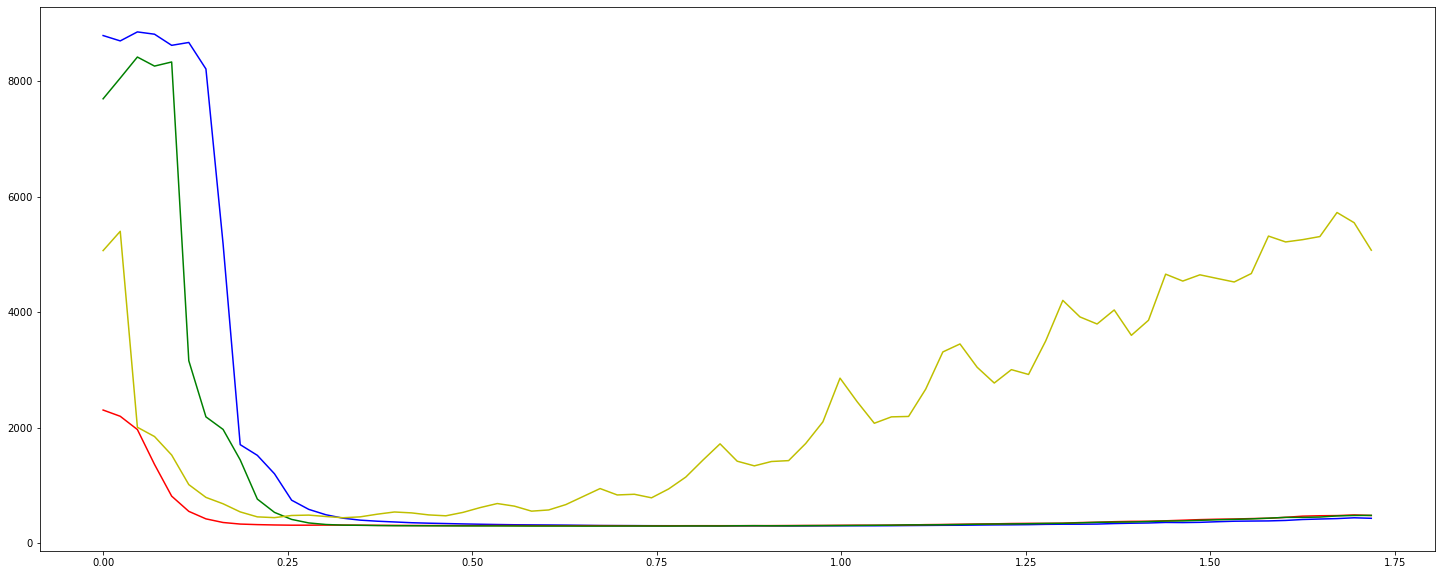

In [44]:
# Visualize spectral sentroid

plt.figure(figsize=(25,10))
plt.plot(t, sc_yarn, color='b')
plt.plot(t, sc_rubber, color='r')
plt.plot(t, sc_cord, color = 'g')
plt.plot(t, sc_dead, color = 'y')
plt.show()

Another option is to calculate the bandwidth.  

In [45]:
# Calculate bandwidth

sb_yarn = librosa.feature.spectral_bandwidth(y = yarn_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
sb_rubber = librosa.feature.spectral_bandwidth(y = rubber_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
sb_cord = librosa.feature.spectral_bandwidth(y = cord_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
sb_dead = librosa.feature.spectral_bandwidth(y = dead_c4, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]

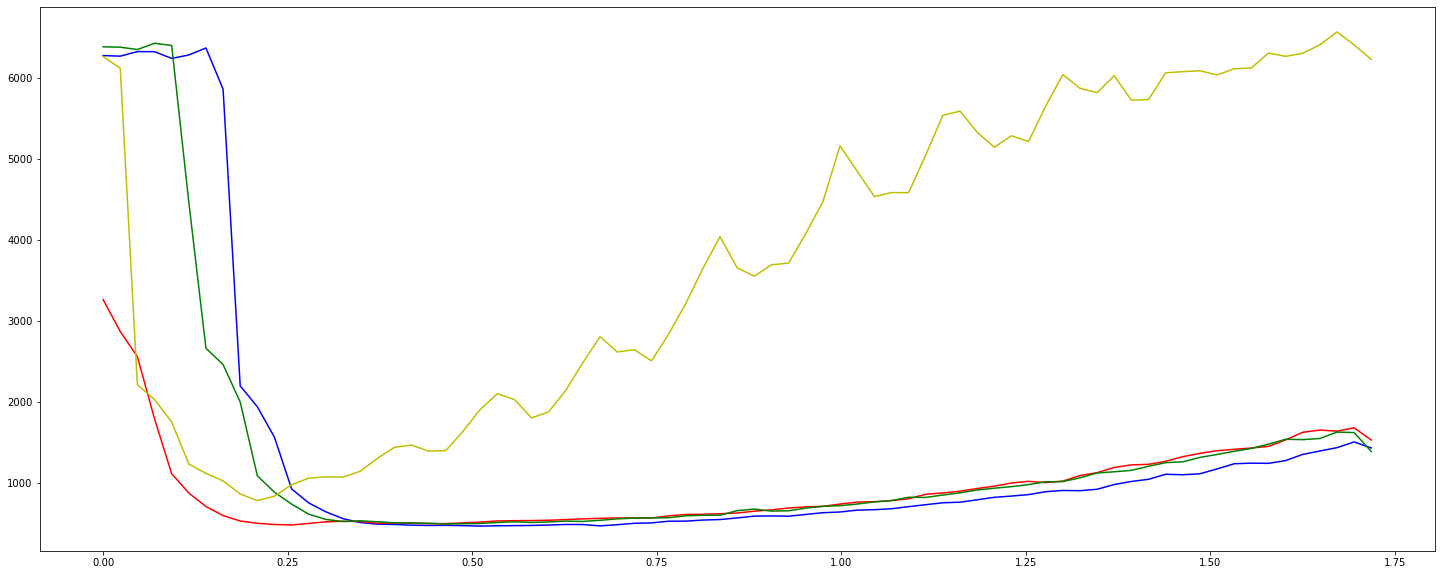

In [46]:
# Visualize spectral bandwidth

plt.figure(figsize=(25,10))
plt.plot(t, sb_yarn, color='b')
plt.plot(t, sb_rubber, color='r')
plt.plot(t, sb_cord, color = 'g')
plt.plot(t, sb_dead, color = 'y')
plt.show()

Based on all these visualizations it is quite possible that we can train a computer to identify the type of mallet that is being used. For starters let’s just give the computer a bunch of waveforms which include all the notes on a four-octave marimba being played by either a cord, yarn or rubber mallet.   

In [47]:
# create a list for the notes on the marimba

notes = ['A2', 'A3', 'A4','A5', 'A6', 'Ab2', 'Ab3', 'Ab4', 'Ab5', 'Ab6',
         'B2', 'B3', 'B4','B5', 'B6', 'Bb2', 'Bb3', 'Bb4', 'Bb5', 'Bb6',
        'C2', 'C3', 'C4','C5', 'C6', 'Bb2',
        'D3', 'D4','D5', 'D6', 'Db2', 'Db3', 'Db4', 'Db5', 'Db6',
        'E2', 'E3', 'E4','E5', 'E6', 'Eb2', 'Eb3', 'Eb4', 'Eb5', 'Eb6',
        'F2', 'F3', 'F4','F5', 'F6', 
        'G2', 'G3', 'G4','G5', 'G6', 'Gb2', 'Gb3', 'Gb4', 'Gb5', 'Gb6',]

In [48]:
len(notes)

60

In [49]:
# Create a dataframe using the wavefiles from all the notes on the marimba played with different mallets
# Please be patient, this may take a while.

mallet = ['yarn', 'cord', 'rubber']
waves = []


for m in range(len(mallet)):   
    for i in notes:
        note_i, sr = librosa.load(mallet[m] + '/Marimba.' + mallet[m] + '.ff.' + i + '.stereo.aif', sr=44100)
        waves.append(note_i)
    
df_waves = pd.DataFrame(waves)

In [50]:
waveform_df = df_waves
df_waves.head()

,0,1,2,3,4,5,6,7,8,9,...,193027,193028,193029,193030,193031,193032,193033,193034,193035,193036
0,0.000006,0.000013,5.245209e-06,-1.782179e-05,-0.000018,-0.000012,0.000008,0.000011,0.000004,-1.162291e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000009,0.000005,2.384186e-07,-5.304813e-06,-0.000006,0.000006,-0.000002,0.000034,-0.000014,1.239777e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000015,0.000008,8.881092e-06,-2.980232e-07,-0.000007,0.000015,0.000001,-0.000006,0.000009,6.556511e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.000014,0.000019,2.878904e-05,1.770258e-05,0.000006,0.000016,0.000013,0.000049,0.000038,3.463030e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.000160,-0.000166,-1.443624e-04,-1.535416e-04,-0.000139,-0.000134,-0.000146,-0.000135,-0.000153,-1.280308e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Create a list for the mallets that are used with each note

mallets = []
for i in range(60):
    mallets.append('yarn')

for i in range(60):
    mallets.append('cord')
    
for i in range(60):
    mallets.append('rubber')
    
len(mallets)   

180

In [52]:
notes_len = notes * 3
len(notes_len)

180

In [53]:
# Add columns indicating the type of mallet and note played 

waveform_df['mallet'] = mallets
waveform_df['note'] = notes_len

In [54]:
# As mentioned earlier we need all the waveforms to be the same length.  
# We can do this in pandas by dropping any columns with all nan values
# If we drop all the columns with any nan values we end up loosing the onset of the waveforms
# We will see that the onset of the waveforms is very imports.

waveform_df = waveform_df.dropna(axis=1, how='all')

In [55]:
waveform_df = waveform_df.fillna(0)
waveform_df.head()

,0,1,2,3,4,5,6,7,8,9,...,193029,193030,193031,193032,193033,193034,193035,193036,mallet,note
0,0.000006,0.000013,5.245209e-06,-1.782179e-05,-0.000018,-0.000012,0.000008,0.000011,0.000004,-1.162291e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yarn,A2
1,-0.000009,0.000005,2.384186e-07,-5.304813e-06,-0.000006,0.000006,-0.000002,0.000034,-0.000014,1.239777e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yarn,A3
2,0.000015,0.000008,8.881092e-06,-2.980232e-07,-0.000007,0.000015,0.000001,-0.000006,0.000009,6.556511e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yarn,A4
3,-0.000014,0.000019,2.878904e-05,1.770258e-05,0.000006,0.000016,0.000013,0.000049,0.000038,3.463030e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yarn,A5
4,-0.000160,-0.000166,-1.443624e-04,-1.535416e-04,-0.000139,-0.000134,-0.000146,-0.000135,-0.000153,-1.280308e-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yarn,A6


In [56]:
# Seperate columns out into X and Y components

X_columns = np.arange(0, 193036, 1)
X = waveform_df[X_columns]
y = waveform_df['mallet']


In [57]:
# Create a train and test set from the dataframe

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [58]:
# fit the K_nearest neighbors algorythm with the training data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 9)
knn_answer = knn.fit(X_train, y_train)

In [59]:
# Using your knn classifier, predict the class label using the mean value for each sample.

means = waveform_df.mean()[:-1].values.reshape(1, -1)    
knn = knn_answer    
mallet_prediction = knn.predict(means)

In [60]:
# Using the knn classifier, predict the class labels for the test set X_test

X_test_predict = knn.predict(X_test)

In [61]:
# Find the score (mean accuracy) of your knn classifier using X_test and y_test.

score = knn.score(X_test, y_test)
score

0.28888888888888886

So, this learning algorithm was able to predict the type of mallet used less than 1/3 of the time.  No better than chance.  That did not work.   

One thing I noticed when looking at the waveforms in the time domain, the main difference in the waveforms occurred at the onset of the sound.  Perhaps we can use information about the onset of the sound to train a computer. 

In [62]:
# we need to change the df of waveforms to an array so we can use librosa again

df_waves.drop(labels = ['mallet', 'note'], axis=1, inplace=True)
df_waves = df_waves.fillna(0)
arr = df_waves.to_numpy()
len(arr)

180

In [63]:
# create a detect onset function 

def onset_test(x, sr=44100):
    o_env = librosa.onset.onset_strength(x, sr=sr)
    times = librosa.times_like(o_env, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
    
    return onset_frames[0]

In [64]:
# ensure our array of waveforms is the correct type

onset_arr = df_waves.to_numpy(dtype='float64')

In [65]:
onset_output = []

for i in range(len(onset_arr)):
    onset_output.append(onset_test(onset_arr[i]))

In [66]:
#  Create a function to get the onset strength

def onset_strength(x, sr=44100):
    onset_env_strength = librosa.onset.onset_strength(y=x, sr=sr,
                                         aggregate=np.median,
                                         fmax=8000, n_mels=256)
    return onset_env_strength

In [67]:
strength_output = []

for i in range(len(onset_arr)):
    strength_output.append(onset_strength(onset_arr[i]))

In [68]:
df_onset = pd.DataFrame(strength_output)
df_onset = df_onset.dropna(axis=1, how='all')
print(df_onset.head())

   0    1    2    3    4          5          6          7         8    \
0  0.0  0.0  0.0  0.0  0.0   1.667979  26.045172   4.578773  0.000000   
1  0.0  0.0  0.0  0.0  0.0   0.000000   0.000000   0.000000  1.576187   
2  0.0  0.0  0.0  0.0  0.0   0.000000   0.000000  24.883679  4.108021   
3  0.0  0.0  0.0  0.0  0.0  26.006380  16.340967   0.616129  0.000000   
4  0.0  0.0  0.0  0.0  0.0   0.000000   0.000000   0.000000  0.000000   

         9    ...  368  369  370  371  372  373  374  375  376  377  
0   0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  30.684388  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2   0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3   0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4   0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 378 columns]


In [69]:
df_onset[378] = onset_output
df_onset.head()

,0,1,2,3,4,5,6,7,8,9,...,369,370,371,372,373,374,375,376,377,378
0,0.0,0.0,0.0,0.0,0.0,1.667979,26.045172,4.578773,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.576187,30.684388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,24.883679,4.108021,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,26.006380,16.340967,0.616129,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10


In [70]:
df_onset['mallet'] = mallets
df_onset['note'] = notes_len

In [71]:
# Seperate columns out into X and Y components

X_columns = np.arange(0, 378, 1)
X = df_onset[X_columns]
y = df_onset['mallet']

In [72]:
# # Create a train and test set from the dataframe

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [73]:
# fit the K_nearest neighbors algorythm with the training data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn_answer = knn.fit(X_train, y_train)

In [74]:
# Using your knn classifier, predict the class label using the mean value for each sample.

means = df_onset.mean()[:-1].values.reshape(1, -1)    
knn = knn_answer    
mallet_prediction = knn.predict(means)

In [75]:
# Using the knn classifier, predict the class labels for the test set X_test

X_test_predict = knn.predict(X_test)

In [76]:
# Find the score (mean accuracy) of your knn classifier using X_test and y_test.

score = knn.score(X_test, y_test)
score

0.6888888888888889

With a KNN value of 1, the computer is able to correctly predict the mallet type used with 68% accuracy.  If I get to continue with project my goals will be to try adding other features as well as using different computer learning algorithms.   

As every percussionist already knows, the type of mallet makes a difference. 